In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mydata/mydata/vali/S1167L/S1167L08.jpg
/kaggle/input/mydata/mydata/vali/S1167L/S1167L01.jpg
/kaggle/input/mydata/mydata/vali/S1043L/S1043L06.jpg
/kaggle/input/mydata/mydata/vali/S1043L/S1043L09.jpg
/kaggle/input/mydata/mydata/vali/S1212L/S1212L01.jpg
/kaggle/input/mydata/mydata/vali/S1212L/S1212L05.jpg
/kaggle/input/mydata/mydata/vali/S1168R/S1168R06.jpg
/...
/kaggle/input/datacheck/datacheck/train/S1006R/S1006R05.jpg
/kaggle/input/datacheck/datacheck/train/S1006R/S1006R01.jpg
/kaggle/input/datacheck/datacheck/train/S1006R/S1006R02.jpg
/kaggle/input/datacheck/datacheck/train/S1006R/S1006R04.jpg
/kaggle/input/datacheck/datacheck/train/S1006R/S1006R03.jpg
/kaggle/input/model_96807/pytorch/model_96807/1/best_model (6).pt


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from random import randint
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import imp
from IPython.display import clear_output
import pandas as pd
bs = 32

from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils
from torch.autograd import Variable

2024-06-12 21:22:19.973618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 21:22:19.973736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 21:22:20.103901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_24/2128068159.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [3]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
# Load the training dataset
folder_dataset_train = datasets.ImageFolder(root="/kaggle/input/roi-output2/ROI_output/train")
folder_dataset_test = datasets.ImageFolder(root="/kaggle/input/roi-output2/ROI_output/test")

In [6]:
# Resize the images and transform to tensors
train_transformation = transforms.Compose([
    transforms.Resize((200, 200)),  # Thay đổi kích thước ảnh về 200x200
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang ảnh với xác suất 50%
    transforms.RandomVerticalFlip(p=0.5),  # Lật dọc ảnh với xác suất 50%
    transforms.RandomRotation(degrees=30),  # Xoay ngẫu nhiên ảnh trong khoảng 30 độ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Điều chỉnh độ sáng, tương phản, bão hòa màu và màu sắc ngẫu nhiên
    transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
])

test_transformation = transforms.Compose([
    transforms.Resize((200, 200)),  # Thay đổi kích thước ảnh về 200x200
    transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
])
# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=train_transformation)
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=test_transformation)

In [7]:
# In ra kích thước của 1 ảnh sau khi áp dụng biến đổi
sample_img = siamese_dataset[0][0]
print("Kích thước của 1 ảnh sau khi áp dụng biến đổi:", sample_img.shape)

# In ra kích thước của 1 phần tử trong siamese_dataset
sample_element = siamese_dataset[0]
print("Kích thước của 1 phần tử trong siamese_dataset:", len(siamese_dataset))

Kích thước của 1 ảnh sau khi áp dụng biến đổi: torch.Size([1, 200, 200])
Kích thước của 1 phần tử trong siamese_dataset: 2600


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


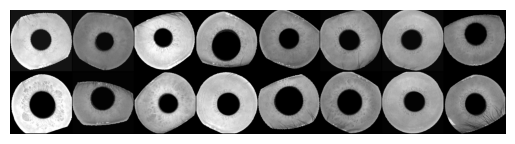

[1. 1. 1. 1. 1. 1. 0. 1.]


In [8]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 0, it means that it is not the same person, label is 1, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [9]:
siamese_dataloader = DataLoader(siamese_dataset, batch_size=bs , shuffle = True)


In [10]:
distance = nn.PairwiseDistance(p=1)
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [11]:
!pip install einops
clear_output()

In [12]:
import torch
import numpy as np
from torch import nn
from einops.layers.torch import Rearrange


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class MixerBlock(nn.Module):
    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super().__init__()
        
        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')
        )
        
        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, channel_dim, dropout),
        )
    def forward(self, x):
        x = x + self.token_mix(x)
        x = x + self.channel_mix(x)
        
        
        return x


class HybridModel(nn.Module):
    def __init__(self, in_channels, dim, inner_dim, num_classes, depth, token_dim, channel_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,inner_dim,kernel_size=3,padding=1),  # Thay đổi in_channels thành 3
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(inner_dim),
            nn.GELU(),
            nn.Conv2d(inner_dim,dim,kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(dim),
            nn.GELU(),
            Rearrange('b c h w -> b (h w) c'),
        )
        
        self.mixer_blocks = nn.ModuleList([])
        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim, 256, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(dim)
        self.linear = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.conv(x)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)
        x = self.layer_norm(x)
        x = x.mean(dim=1)
        x = self.linear(x)
        return x

In [13]:
model1 = HybridModel(in_channels=1, num_classes=2, dim=256, inner_dim=128, depth=1, token_dim=512, channel_dim=512)
checking = torch.rand([1,1,64,64])
model1(checking).shape

torch.Size([1, 2])

In [14]:
class convMixerLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size) -> None:
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels=in_channel, 
            out_channels=out_channel, 
            groups=in_channel, 
            kernel_size=kernel_size,
            stride=1,
            padding="same"
        )
        self.pointwise = nn.Conv2d(in_channel, out_channel, 1, 1)
        self.activation = nn.GELU()
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)
        #self.trans = MHSA(n_dims = out_channel, width=64, height=64, heads=4)
    
    def forward(self, x):
        ori = x
        #x = self.trans(x)
        x = self.depthwise(x)
        x = self.activation(x)
        x = self.batchnorm1(x) + ori
        x = self.pointwise(x)
        x = self.activation(x)
        x = self.batchnorm2(x)
        return x

class SiameseNetwork(nn.Module):
    def __init__(self, patch_size = 3, kernel_size = 3, h = 64, depth = 10, num_classes = 2) -> None:
        super().__init__()
        self.depth = depth
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=h, kernel_size=patch_size, stride=patch_size),  # Thay đổi in_channels thành 3
            nn.GELU(),
            nn.BatchNorm2d(h)
        )
        convmix = [convMixerLayer(h, h, kernel_size) for i in range(depth)]
        self.convmix = nn.Sequential(*convmix)
        self.gbpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(h, num_classes)
        #self.trans = MHSA(n_dims = h, width=21, height=21, heads=4)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.convmix(x)
        #---Transformer---#
        #x = self.trans(x)
        #-----------------#
        x = self.gbpool(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [15]:
model = SiameseNetwork()


In [16]:
# Tính toán mean và std trên train_data
train_data = torch.stack([siamese_dataset[i][0] for i in range(len(siamese_dataset))])
mean = train_data.mean()
std = train_data.std()

# Chuyển đổi kết quả sang kiểu tensor và đưa lên GPU (nếu có)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mean = mean.to(device)
std = std.to(device)

# To CUDA (nếu bạn muốn đưa model lên GPU)
model = model.to(device)

In [17]:
def Train(model, criterion, optimizer, siamese_dataloader, device, mean, std):
    model.train()
    running_loss=0
    num_batches=0
    for i, data in enumerate(siamese_dataloader, 0):
        img1, img2 , label = data
        img1 = img1.to(device)
        img2 = img2.to(device)
        img1 = (img1 - mean)/std
        img2 = (img2 - mean)/std
        label = label.to(device)
        optimizer.zero_grad()
        output1 = model(img1)
        output2 = model(img2)
        distance_score = distance(output1, output2)
        distance_score = distance_score.unsqueeze(dim=1)
        ##---------Using constrastive loss------#
        loss = criterion(output1, output2, label)
        #---------Using casual loss------------#
        #loss = criterion(distance_score, label)
        loss.backward()
        optimizer.step()
        loss_detech = loss.detach().item()
        running_loss += loss_detech
        num_batches += 1
        #---Compute average loss per batchsize----#
        loss_bs = running_loss/num_batches
    return loss_bs

In [18]:
siamese_dataloader_check = DataLoader(siamese_dataset, batch_size=1, shuffle=True)
siamese_dataloader_test = DataLoader(siamese_dataset_test, batch_size=1, shuffle=False)
def On_Testset(model, siamese_dataloader_test, mean, std, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(siamese_dataloader_test):
            img1, img2, label = data
            img1 = img1.to(device)
            img2 = img2.to(device)
            img1 = (img1 - mean)/std
            img2 = (img2 - mean)/std
            label = label.to(device)
            output1 = model(img1)
            output2 = model(img2)
            #output1, output2 = model(img1, img2)
            euclidean_distance = distance(output1, output2)
            if (euclidean_distance < 0.5):
              predictions = 0
            else:
              predictions = 1
            #predictions = torch.lt(euclidean_distance, 0.5).tolist()
            total += label.size(0)
            correct += sum(np.array(predictions) == label.tolist())
        accuracy = (correct / total)
    return accuracy.item()

In [19]:
criterion = ContrastiveLoss()
#criterion = nn.MSELoss()
#criterion = nn.BCEWithLogitsLoss()
lr = 0.001
from torch.optim import Adam
# Define the loss function and optimizer
full_loss=[]
start=time.time()
the_best_acc = 0
acc_test = []
# # train the model
# for epoch in range(1,200):
#     optimizer = Adam(model.parameters(), lr=lr, )  
#     loss_bs = Train(model, criterion, optimizer, siamese_dataloader, device, mean, std)
#     acc = On_Testset(model, siamese_dataloader_test, mean, std, device)

#     #----Stored loss, accuracy per epoch-----#
#     acc_test.append(acc)
#     elapsed = (time.time()-start)/60
#     full_loss.append(loss_bs)
#     print('epoch=',epoch, '\t time={:.5f} min'.format(elapsed),'\t loss={:.5f}'.format(loss_bs), '\t Accuracy on Test set = {:.5f}'.format(acc))
#     #---------Save the best model------------#
#     if acc > the_best_acc:
#         the_best_acc = acc
#         print("==> This is the best model with Accuracy on test set is {:.5f}".format(acc))
#         #save if needed
#         data_path='/kaggle/working/'
#         torch.save(model,data_path+'best_model.pt')
#     torch.cuda.empty_cache()
# print("Training completed")

In [20]:
#-----Load the best model------#
model = torch.load('/kaggle/input/model_96807/pytorch/model_96807/1/best_model (6).pt')

In [21]:
#--accuracy of the best model--#
On_Testset(model, siamese_dataloader_test, mean, std, device)

0.9579100145137881

In [22]:
model.cpu()


SiameseNetwork(
  (patch_embed): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(3, 3))
    (1): GELU(approximate='none')
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convmix): Sequential(
    (0): convMixerLayer(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=64)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (activation): GELU(approximate='none')
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): convMixerLayer(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=64)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (activation): GELU(approximate='none')
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [23]:
import h5py
with h5py.File('model.h5', 'w') as f:
    for name, param in model.named_parameters():
        f.create_dataset(name, data=param.detach().numpy())

In [24]:
model.eval()
model = model.to(device)

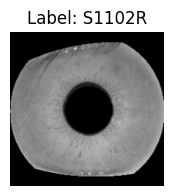

In [25]:

# Helper functions
def imshow(img, label=None, text=None):
    npimg = img.numpy()
    plt.figure(figsize=(2, 2))
    plt.axis("off")
    if text:
        plt.text(0, -10, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if label is not None:
        plt.title(f"Label: {label}")
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

# Siamese network dataset
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        img_path, _ = self.imageFolderDataset.imgs[index]  # Lấy đường dẫn ảnh
        img = Image.open(img_path).convert("L")

        if self.transform is not None:
            img = self.transform(img)

        label = img_path.split('/')[-2]  # Lấy nhãn từ đường dẫn ảnh

        return img, label

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

# Load the training and test datasets
folder_dataset_train = datasets.ImageFolder(root="/kaggle/input/roi-output2/ROI_output/train")
folder_dataset_test = datasets.ImageFolder(root="/kaggle/input/roi-output2/ROI_output/test")

# Transformation
transformation = transforms.Compose([
    transforms.Resize((200, 200)),  # Thay đổi kích thước ảnh về 200x200
    transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
])

# Initialize the network datasets
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=transformation)
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                             transform=transformation)

# Create a simple dataloader for visualization
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=1)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch contains images and labels
images, labels = example_batch

# Display images with their original labels
for img, label in zip(images, labels):
    imshow(torchvision.utils.make_grid(img), label=label)

Test Image with Label S1017R:


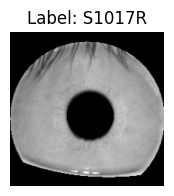

Comparison Image with Same Label S1017R: Dissimilarity: 0.27


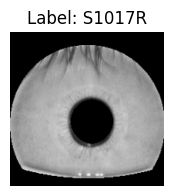

Test Label S1017R with Different Label S1248L: Dissimilarity: 1.08


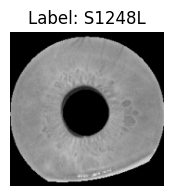

Test Label S1017R with Different Label S1007R: Dissimilarity: 1.44


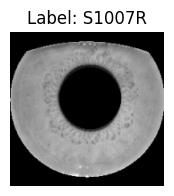

Test Label S1017R with Different Label S1045R: Dissimilarity: 0.83


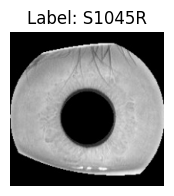

Test Label S1017R with Different Label S1102R: Dissimilarity: 0.63


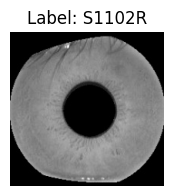

In [26]:
test_image, test_label = siamese_dataset_test[random.randint(0, len(siamese_dataset_test) - 1)]

# Mở rộng kích thước của hình ảnh mẫu để tạo thành tensor 4 chiều
test_image = test_image.unsqueeze(0).to(device)

# Sử dụng mô hình để tính toán đầu ra cho hình ảnh mẫu
output1 = model(test_image)

# Hiển thị hình ảnh mẫu với nhãn của nó
print(f"Test Image with Label {test_label}:")
imshow(torchvision.utils.make_grid(test_image.cpu()), label=test_label)

# Tìm và hiển thị một hình ảnh khác cùng nhãn và độ khác biệt của nó
found_same_label = False
while not found_same_label:
    comparison_image, comparison_label = siamese_dataset_test[random.randint(0, len(siamese_dataset_test) - 1)]
    if comparison_label == test_label:
        found_same_label = True
        comparison_image = comparison_image.unsqueeze(0).to(device)
        output2 = model(comparison_image)
        euclidean_distance = F.pairwise_distance(output1, output2).item()
        print(f"Comparison Image with Same Label {comparison_label}: Dissimilarity: {euclidean_distance:.2f}")
        imshow(torchvision.utils.make_grid(comparison_image.cpu()), label=comparison_label)

# Tìm và hiển thị các hình ảnh khác nhãn và độ khác biệt của chúng
num_additional_images = 4
for _ in range(num_additional_images):
    found_different_label = False
    while not found_different_label:
        additional_image, additional_label = siamese_dataset_test[random.randint(0, len(siamese_dataset_test) - 1)]
        if additional_label != test_label:
            found_different_label = True
            additional_image = additional_image.unsqueeze(0).to(device)
            additional_output = model(additional_image)
            additional_distance = F.pairwise_distance(output1, additional_output).item()
            print(f"Test Label {test_label} with Different Label {additional_label}: Dissimilarity: {additional_distance:.2f}")
            imshow(torchvision.utils.make_grid(additional_image.cpu()), label=additional_label)